This competition's dataset provides 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

This competition challenges you to predict the final price of each home.

# Step 0 - Preliminaries
First, i will import common packages and set some notebook defaults.

In [4]:
# Importing common packages.
import os                                        #For communication with the Operative System.
import warnings                                  #Just in case I need to hide some warnings.

import numpy as np               
import pandas as pd              

#Graphical and plotting packages:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display              #Public API for display tools in IPython.

from pandas.api.types import CategoricalDtype    #Check if the provided array or dtype is Categorical

#Feature Engineering
from sklearn.feature_selection import mutual_info_regression   #Mutual Information
from category_encoders import MEstimateEncoder   #Target encoding 
from sklearn.cluster import KMeans               #Clustering
from sklearn.decomposition import PCA            #Principal Component Analysis
from sklearn.feature_selection import RFECV                 #Recursive Feature Selection

#Models
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold, cross_val_score
import sklearn.linear_model as linear_model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

#import dabl                                      #Data Analysis and ML Automation
from sklearn.metrics import mean_squared_error              #Metric

# Mute warnings
warnings.filterwarnings('ignore')

In [5]:
#!pip install category_encoders
#!pip install dabl
#!pip install xgboost
#!pip install lightgbm

In [6]:
# Set Matplotlib defaults
%matplotlib inline
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10
)

# Step 1 - Data Preprocessing

Let's preprocess the data to get it in a form suitable for analysis. 

For the Ames competition dataset, I'll need to:

-Load the data from CSV files
-Clean the data to fix any errors or inconsistencies
-Encode the statistical data type (numeric, categorical)
-Impute any missing values

I'll wrap all these steps up in a function, which will make it easy to apply to new dataframes whenever I need.

## 1.1 Load data.
It loads the data from CSV files in my GitHub, and apply clean, encode and impute functions, that will be defined later in this step.

In [4]:
#Load the data

def load_data():
    # Read data
    data_dir = Path("https://raw.githubusercontent.com/jdcimadoro/House-Prices-Regression/main/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so I can preprocess them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Undo merge, reform splits.
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

## 1.2 Clean Data.

Data_description.txt has a full description of each column.

Some of the categorical features in this dataset have what are apparently typos in their categories.
Comparing these to data_description.txt shows me what needs cleaning.



In [11]:
# Read data
data_dir = "https://raw.githubusercontent.com/jdcimadoro/House-Prices-Regression/main/"
df_train = pd.read_csv(data_dir + "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir + "test.csv", index_col="Id")
# Merge the splits so I can preprocess them together
df = pd.concat([df_train, df_test])

In [71]:
for col,value in df.iteritems():
    print ('*'*20)
    print (col)
    print (value.value_counts())
    #col.value_counts(sort=False, ascending=False)

********************
MSSubClass
20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
********************
MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
********************
LotFrontage
60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
        ... 
144.0      1
111.0      1
123.0      1
155.0      1
31.0       1
Name: LotFrontage, Length: 128, dtype: int64
********************
LotArea
9600     44
7200     43
6000     34
9000     29
10800    25
         ..
11787     1
9738      1
7689      1
9736      1
8190      1
Name: LotArea, Length: 1951, dtype: int64
********************
Street
Pave    2907
Grvl      12
Name: Street, dtype: int64
********************
Alley
Grvl    120
Pave     78
Name: Alley, dtype: int64
********************
Lot

The first step is Exploratory Data Analysis.

In [5]:
#see samples on train dataset

train.head()

#We store Id features in a variables and will use them to send predictions to the leaderboard.

train_ID = train['Id']
test_ID = test['Id']

In [6]:
#see the shapes of training and testing datasets

print('Training set shape:', train.shape)
print('Testing set shape:', test.shape)

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

Training set shape: (1460, 81)
Testing set shape: (1459, 80)


In [8]:
#Automatically plots for performing EDA and detect anomalies in dataset

### However, we are not going to do this for testing dataset and after because even though we detect anomalies in testing set,
# we could not delete rows with such anomalies.

# dabl.plot(train, 'SalePrice')

In [9]:
# see the training set structure
# train.info()
# train.head()

In [10]:
#Some of the features are seen as numericals and they may be categoricals and others must be datetypes and they are numericals. So we transform them.

train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0], inplace=True)
train['GarageDateBlt'] = pd.to_datetime(train['GarageYrBlt'], format='%Y') 

train.drop(["GarageYrBlt"], axis = 1, inplace = True) 

train['MSSubClass'] = train['MSSubClass'].apply(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

train['DateBuilt'] = pd.to_datetime(train['YearBuilt'], format='%Y') 


train['DateSold'] = pd.to_datetime(train['YrSold'], format='%Y') 


train['DateRemodAdd'] = pd.to_datetime(train['YearRemodAdd'], format='%Y') 

train.drop(["YearBuilt", "YrSold", "YearRemodAdd"], axis = 1, inplace = True) 

In [11]:
#Some of the features are seen as numericals and they may be categoricals and others must be datetypes and they are numericals. So we transform them.

test['GarageYrBlt'].fillna(test['GarageYrBlt'].mode()[0], inplace=True)
test['GarageDateBlt'] = pd.to_datetime(test['GarageYrBlt'], format='%Y') 

test.drop(["GarageYrBlt"], axis = 1, inplace = True) 

test['MSSubClass'] = test['MSSubClass'].apply(str)
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

test['DateBuilt'] = pd.to_datetime(test['YearBuilt'], format='%Y') 


test['DateSold'] = pd.to_datetime(test['YrSold'], format='%Y') 


test['DateRemodAdd'] = pd.to_datetime(test['YearRemodAdd'], format='%Y') 

test.drop(["YearBuilt", "YrSold", "YearRemodAdd"], axis = 1, inplace = True) 

In [12]:
#Function for finding numerical and categorical features

def characteristics(dataset):
    print('Shape of the dataset: {}'.format(dataset.shape))
    dataset_numerical = dataset.select_dtypes(include = [np.number])
    print('Number of Numerical Features: {}'.format(dataset_numerical.shape[1]))
    dataset_categorical = dataset.select_dtypes(exclude = [np.number])
    print('Number of Categorical Features: {}'.format(dataset_categorical.shape[1]))

In [13]:
characteristics(train)

Shape of the dataset: (1460, 80)
Number of Numerical Features: 31
Number of Categorical Features: 49


In [14]:
characteristics(test)

Shape of the dataset: (1459, 79)
Number of Numerical Features: 30
Number of Categorical Features: 49


In [15]:
#Variables for storing numerical and categoricals features in training dataset

numerical_train = train.select_dtypes(include = [np.number])
numerical_features = numerical_train.columns

categorical_train = train.select_dtypes(exclude = [np.number])
categorical_features = categorical_train.columns

In [16]:
#Variables for storing numerical and categoricals features in testing dataset

numerical_test = test.select_dtypes(include = [np.number])
numerical_features = numerical_test.columns

categorical_test = test.select_dtypes(exclude = [np.number])
categorical_features = categorical_test.columns

In [17]:
# Deleting features with more than 96% of common values in both dataset because these features won't be efficient to predict "SalePrice".

overfit_categorical_train = []
for i in categorical_train:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 96:
        overfit_categorical_train.append(i)

overfit_categorical_train = list(overfit_categorical_train)
test = test.drop(overfit_categorical_train, axis=1)
train = train.drop(overfit_categorical_train, axis=1)

In [18]:
overfit_numerical_train = []
for i in numerical_train:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 96:
        overfit_numerical_train.append(i)

overfit_numerical_train = list(overfit_numerical_train)
test = test.drop(overfit_numerical_train, axis=1)
train = train.drop(overfit_numerical_train, axis=1)

In [19]:
print("Categorical Features with >96% of the same value: ",overfit_categorical_train)
print("Numerical Features with >96% of the same value: ",overfit_numerical_train)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


In [20]:
print('Training set shape is now :', train.shape)

Training set shape is now : (1460, 71)


In [21]:
print('Testing set shape is now :', test.shape)

Testing set shape is now : (1459, 70)


In [22]:
#Variables for storing numerical and categoricals features in training dataset

numerical_train = train.select_dtypes(include = [np.number])
numerical_features = numerical_train.columns
categorical_train = train.select_dtypes(exclude = [np.number])
categorical_features = categorical_train.columns

In [23]:
#Variables for storing numerical and categoricals features in testing dataset

numerical_test = test.select_dtypes(include = [np.number])
numerical_features = numerical_test.columns

categorical_test = test.select_dtypes(exclude = [np.number])
categorical_features = categorical_test.columns

# Outliers detection


#### The presence of outliers in a classifcation or regression dataset can result in a poor fit and lower predictive modeling performance.<br> In that way, we have to treat them effectively before modeling.<br>

#### The first thing to do when we want to see if there are outliers in our training dataset is to plot all variables in but we are not going <br>to perform outliers detection on our testing dataset.

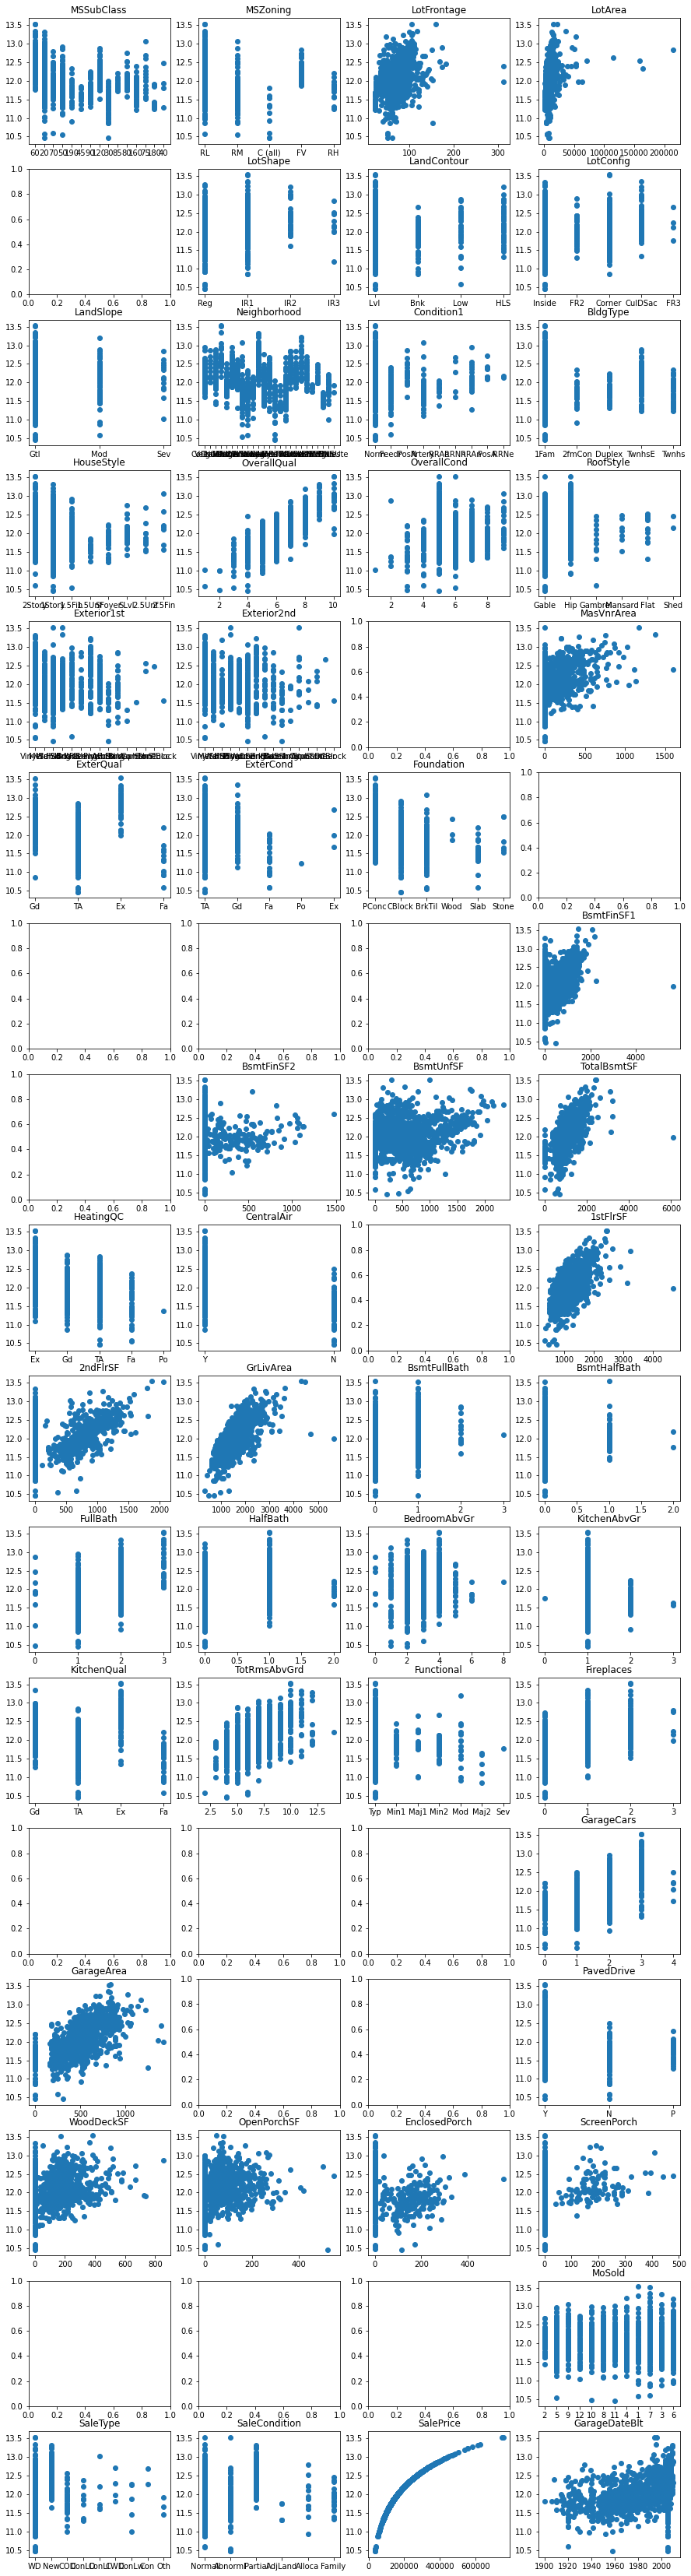

In [24]:
#Plots for helping determine outliers

train.shape[1]
#a = int(np.sqrt(train.shape[1]))
a = 4
b = int(train.shape[1]/4)
r = int(train.shape[1]/a)
c = int(train.shape[1]/b)
i = 0
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(15, 60))
for row in ax:
    for col in row:
        try:
            col.scatter(x = train[train.columns[i]], y = np.log(train['SalePrice']))
            col.title.set_text(train.columns[i])
        except:
            temp=1
        #except Exception as e:
        #    print(e.message, e.args)
        finally:
            temp=1
        i = i + 1
        
plt.show()

#### As seen with plots, we have several outliers in our training dataset<br>
#### I will read plots and delete rows manually when certains conditions are not repected;<br>

In [25]:
#This is a heavy plot, be patient.
#fig = plt.figure(figsize=(20,15))
#for index,col in enumerate(numerical_train):
#    plt.subplot(6,5,index+1)
#    sns.countplot(x=col, data=numerical_train.dropna())
#fig.tight_layout(pad=1.0)

In [26]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)
train = train.drop(train[train['EnclosedPorch'] > 401].index)
train.reset_index(drop=True, inplace=True)

In [27]:
trt = train.copy()
outliers = []

outliers.append(trt[trt['1stFlrSF']>2700][trt['SalePrice']<500_000].index)
outliers.append(trt[trt['BsmtFullBath']==3.0].index)
outliers.append(trt[trt['GrLivArea']>3300][trt['SalePrice']<300_000].index)
outliers.append(trt[trt['FullBath']==0.0][trt['SalePrice']>300_000].index)
outliers.append(trt[trt['GarageArea']>1200][trt['SalePrice']<200_000].index)
outliers.append(trt[trt['OpenPorchSF']>500].index)

outliers = [x[0] for x in outliers]
outliers
train.drop(outliers, axis=0, inplace=True)
train.shape

/home/j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(1444, 71)

In [28]:
def characteristics(dataset):
    print('Shape of the dataset: {}'.format(dataset.shape))
    dataset_numerical = dataset.select_dtypes(include = [np.number])
    print('Number of Numerical Features: {}'.format(dataset_numerical.shape[1]))
    dataset_categorical = dataset.select_dtypes(exclude = [np.number])
    print('Number of Categorical Features: {}'.format(dataset_categorical.shape[1]))

In [29]:
characteristics(train)

Shape of the dataset: (1444, 71)
Number of Numerical Features: 27
Number of Categorical Features: 44


In [30]:
characteristics(test)

Shape of the dataset: (1459, 70)
Number of Numerical Features: 26
Number of Categorical Features: 44


# Handling missing values


### Missing values <br> In that way, we have to treat them effectively before modeling.<br>

In [31]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:71]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(50)

,Missing Ratio
PoolQC,99.722992
MiscFeature,96.468144
Alley,93.698061
Fence,80.747922
FireplaceQu,47.576177
LotFrontage,17.659280
GarageType,5.470914
GarageFinish,5.470914
GarageQual,5.470914
GarageCond,5.470914


Text(0.5, 1.0, 'Percent missing data by feature')

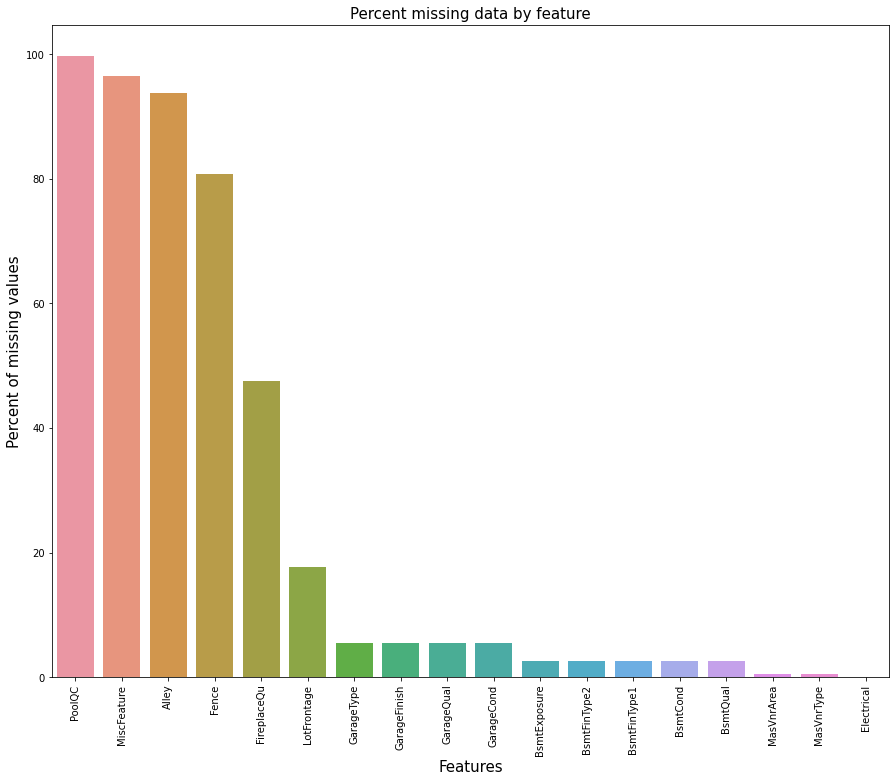

In [32]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [33]:
train["PoolQC"] = train["PoolQC"].fillna("None")
train["MiscFeature"] = train["MiscFeature"].fillna("None")
train["Alley"] = train["Alley"].fillna("None")
train["Fence"] = train["Fence"].fillna("None")
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
train["MasVnrType"] = train["MasVnrType"].fillna("None")


train["GarageType"] = train["GarageType"].fillna("None")
train["GarageFinish"] = train["GarageFinish"].fillna("None")
train["GarageQual"] = train["GarageQual"].fillna("None")
train["GarageCond"] = train["GarageCond"].fillna("None")
train["BsmtQual"] = train["BsmtQual"].fillna("None")
train["BsmtCond"] = train["BsmtCond"].fillna("None")
train["BsmtExposure"] = train["BsmtExposure"].fillna("None")
train["BsmtFinType1"] = train["BsmtFinType1"].fillna("None")
train["BsmtFinType2"] = train["BsmtFinType2"].fillna("None")

train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

train['GarageCars'] = train['GarageCars'].fillna(0)

train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

train['Electrical'] = train['Electrical'].fillna("Typ")

In [34]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)[:71]
missing_data = pd.DataFrame({'Missing Ratio' :test_na})
missing_data.head(50)

,Missing Ratio
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270
LotFrontage,15.558602
GarageCond,5.346127
GarageQual,5.346127
GarageFinish,5.346127
GarageType,5.209047


Text(0.5, 1.0, 'Percent missing data by feature in testing dataset')

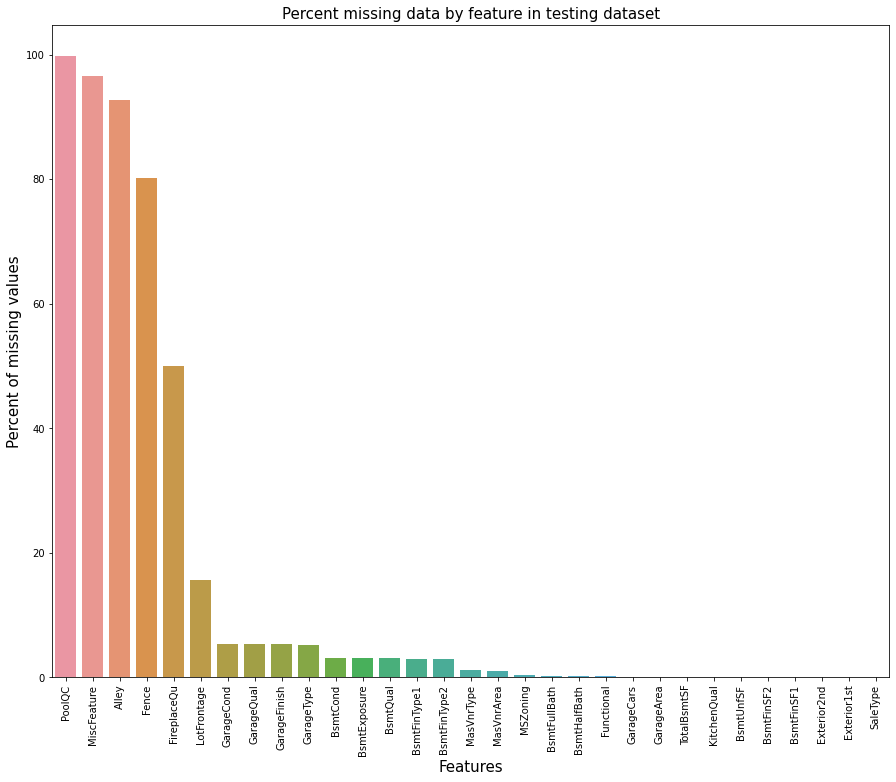

In [35]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=test_na.index, y=test_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature in testing dataset', fontsize=15)

In [36]:
test["PoolQC"] = test["PoolQC"].fillna("None")
test["MiscFeature"] = test["MiscFeature"].fillna("None")
test["Alley"] = test["Alley"].fillna("None")
test["Fence"] = test["Fence"].fillna("None")
test["FireplaceQu"] = test["FireplaceQu"].fillna("None")
test["MasVnrType"] = test["MasVnrType"].fillna("None")


test["GarageType"] = test["GarageType"].fillna("None")
test["GarageFinish"] = test["GarageFinish"].fillna("None")
test["GarageQual"] = test["GarageQual"].fillna("None")
test["GarageCond"] = test["GarageCond"].fillna("None")
test["BsmtQual"] = test["BsmtQual"].fillna("None")
test["BsmtCond"] = test["BsmtCond"].fillna("None")
test["BsmtExposure"] = test["BsmtExposure"].fillna("None")
test["BsmtFinType1"] = test["BsmtFinType1"].fillna("None")
test["BsmtFinType2"] = test["BsmtFinType2"].fillna("None")

test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

test['GarageCars'] = test['GarageCars'].fillna(0)

test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

test['MSZoning'].fillna(test['MSZoning'].mode()[0], inplace=True)
test['Functional'].fillna(test['Functional'].mode()[0], inplace=True)

test['BsmtHalfBath'].fillna(test['BsmtHalfBath'].mode()[0], inplace=True)
test['BsmtFullBath'].fillna(test['BsmtFullBath'].mode()[0], inplace=True)

test['SaleType'].fillna(test['SaleType'].mode()[0], inplace=True)
test['GarageArea'].fillna(test['GarageArea'].mode()[0], inplace=True)
test['KitchenQual'].fillna(test['KitchenQual'].mode()[0], inplace=True)
test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mode()[0], inplace=True)
test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mode()[0], inplace=True)
test['BsmtFinSF2'].fillna(test['BsmtFinSF2'].mode()[0], inplace=True)
test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mode()[0], inplace=True)
test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0], inplace=True)
test['Exterior1st'].fillna(test['Exterior1st'].mode()[0], inplace=True)


In [37]:
#Encoding Categorical variables

categorical_train = train.select_dtypes(exclude = [np.number])
categorical_features = categorical_train.columns

categorical_test = test.select_dtypes(exclude = [np.number])
categorical_features = categorical_test.columns

In [38]:
for i in categorical_train:
    fe = train.groupby(i).size()/len(train)
    train.loc[:, i] = train[i].map(fe)

In [39]:
for i in categorical_test:
    fe = test.groupby(i).size()/len(test)
    test.loc[:, i] = test[i].map(fe)

# Now we gonna start features selection for building our models.

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested. Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.

Three benefits of performing feature selection before modeling your data are:

    Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
    Improves Accuracy: Less misleading data means modeling accuracy improves.
    Reduces Training Time: Less data means that algorithms train faster.

In [40]:
# Deleting features with more than 96% of common values in training dataset because these features won't be efficient to predict "SalePrice".

overfit_categorical_train = []
for i in categorical_train:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 96:
        overfit_categorical_train.append(i)

overfit_categorical_train = list(overfit_categorical_train)
train = train.drop(overfit_categorical_train, axis=1)
test = test.drop(overfit_categorical_train, axis=1)

overfit_numerical_train = []
for i in numerical_train:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 96:
        overfit_numerical_train.append(i)

overfit_numerical_train = list(overfit_numerical_train)
train = train.drop(overfit_numerical_train, axis=1)
test = test.drop(overfit_numerical_train, axis=1)

print("Categorical Features with >96% of the same value: ",overfit_categorical_train)
print("Numerical Features with >96% of the same value: ",overfit_numerical_train)

Categorical Features with >96% of the same value:  ['PoolQC', 'MiscFeature']
Numerical Features with >96% of the same value:  []


In [41]:
correlated_features = set()
correlation_matrix = train.drop('SalePrice', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
for i in correlated_features:
    train.drop(i, axis=1, inplace=True)
    test.drop(i, axis=1, inplace=True)

### As we will build differents models (Robust Regression, Support Vector Regression, XGBoost and Random Forest) and each model has it's features selection criteria, we will perform different features selection algorithms based on each models. <br>

#### For example, if we wanna build a robust regression model, we should select features based on a non-collinearity criteria and looking for overfiting/underfiting too.<br>

#### Also, Linear Kernel of Support vector Regression is very similar to linear Regression, and hence the effect of multicollinearity has a very similar effect in case of Linear Kernel of SVR.<br> So we have to remove multicollinearity between features , if we want to use weight vectors directly for feature importance. 

#### Random Forest uses bootstrap sampling and feature sampling, i.e row sampling and column sampling. Therefore Random Forest is not affected by multicollinearity that much since it is picking different set of features for different models and of course every model sees a different set of data points. But there is a chance of multicollinear features getting picked up together, and when that happens we will see some trace of it.

https://medium.com/@raj5287/effects-of-multi-collinearity-in-logistic-regression-svm-rf-af6766d91f1b

### Models

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

### Now we should notice that all except SVR are good for our dataset. So, we gonna use them.

In [43]:
X_train = train.drop(['SalePrice'],axis=1)
y_train = train['SalePrice']
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

def cv_rmse(model, X_train=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [44]:
score1 = cv_rmse(linear_model.LinearRegression())
print("LinearRegression: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()), )

my_Lasso = linear_model.Lasso(alpha = 2, max_iter = 10000)
score2 = cv_rmse(my_Lasso)
print("Lasso: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()), )

my_DecisionTreeRegressor = DecisionTreeRegressor()
score4 = cv_rmse(my_DecisionTreeRegressor)
print("DecisionTreeRegressor: {:.4f} ({:.4f})\n".format(score4.mean(), score4.std()), )

my_RandomForestRegressor = RandomForestRegressor()
score5 = cv_rmse(my_RandomForestRegressor)
print("RandomForestRegressor: {:.4f} ({:.4f})\n".format(score5.mean(), score5.std()), )

my_GradientBoostingRegressor = GradientBoostingRegressor()
score6 = cv_rmse(my_GradientBoostingRegressor)
print("GradientBoostingRegressor: {:.4f} ({:.4f})\n".format(score6.mean(), score6.std()), )

LinearRegression: 25311.0963 (2545.7536)

Lasso: 25281.3053 (2541.6455)

DecisionTreeRegressor: 38269.2209 (4698.5801)

RandomForestRegressor: 25450.3151 (1872.8612)

GradientBoostingRegressor: 23375.6962 (2033.5043)



In [45]:
my_LGBMRegressor = LGBMRegressor()
score7 = cv_rmse(my_LGBMRegressor)
print("LGBMRegressor: {:.4f} ({:.4f})\n".format(score7.mean(), score7.std()), )

my_XGBRegressor = XGBRegressor()
score8 = cv_rmse(my_XGBRegressor)
print("XGBRegressor: {:.4f} ({:.4f})\n".format(score8.mean(), score8.std()), )

LGBMRegressor: 23870.9442 (2084.3620)

XGBRegressor: 25288.0823 (2006.6829)



In [46]:
X = train.drop('SalePrice', axis=1)
target = train['SalePrice']

# Load a regression dataset
#viz = ValidationCurve(
#    GradientBoostingRegressor, param_name="max_depth",
#    param_range=np.arange(1, 11), cv=10, scoring="r2"
#)

# Fit and show the visualizer
#viz.fit(X, target)
#viz.show()

### This tells us the best model for our dataset is GradientBoostingRegressor and the validation curve shoxs it's adapted to our dataset.

#### Now, let use Recursive Feature Selection for having best features that we gonna use for model optimization.

In [47]:
# Now, we gonna use RFE with linear regression but we could also use VIF Calculation for finding best features for our linear and svr models.

X = train.drop('SalePrice', axis=1)
target = train['SalePrice']


my_GBR = GradientBoostingRegressor()
selector = RFECV(my_GBR)
selector = selector.fit(X, target)
print('Optimal number of features: {}'.format(selector.n_features_))

Optimal number of features: 47


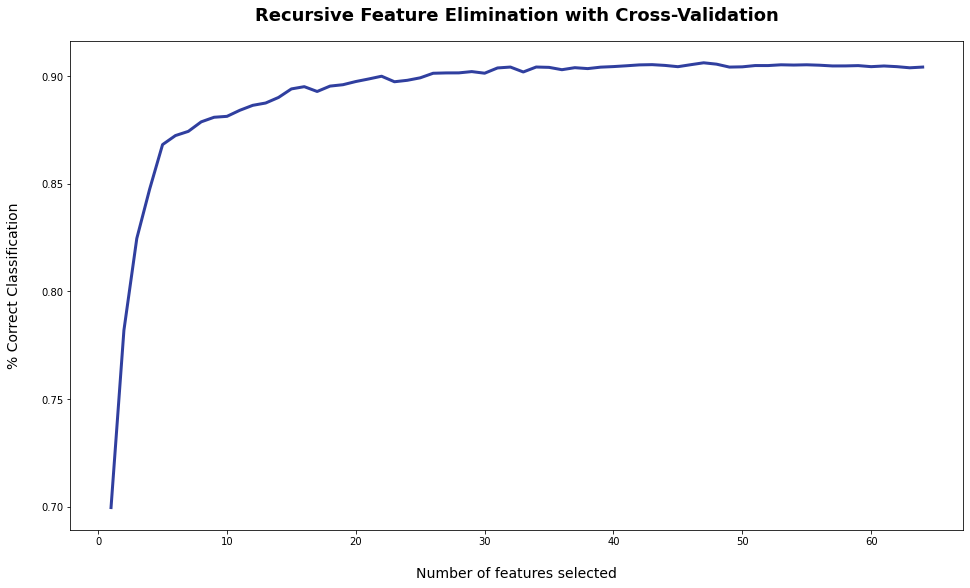

In [48]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [49]:
test.drop(X.columns[np.where(selector.support_ == False)[0]], axis=1, inplace=True)
train.drop(X.columns[np.where(selector.support_ == False)[0]], axis=1, inplace=True)

In [50]:
X = train.drop('SalePrice', axis=1)
target = train['SalePrice']

X_train, X_val, y_train, y_val = tts(X, target, test_size=0.2, random_state=2020)

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

In [52]:
#We did the same thing for GradientBoostingRegressor and detect these hyperparameters are best:

GradientBoostingRegr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
GradientBoostingRegr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000,
                          random_state=42)

In [53]:
Predictions = GradientBoostingRegr.predict(test)

In [54]:
# I'll submit predictions to the competition for scoring on the leaderboard.

submission = pd.DataFrame({'Id': test_ID,
                           'SalePrice': Predictions})
submission.to_csv('submission_boost.csv', index=False)